# Query Google Maps Satellite Tiles from Given Coordinates and Zoom Level

Functions to retrieve Google Maps satellite tiles (256x256 RGB images) from specified longitudes, latitudes, and zoom levels.

Objectives:
- Retrieve the tile at a specified zoom level that covers a user-specified (longitude, latitude)
- Correctly georeference the tile (bounds of the tile, coordinates of the center of every pixel/mesh)

Preliminary work for a computer vision project...

Cyril Joly

In [1]:
from io import BytesIO

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
import rioxarray as rio
import xarray as xr
from geometry_utils import encode_dataset, get_coordinates
from PIL import Image
from shapely.geometry import box


def download_tile(lon, lat, zoom):
    xtile, ytile = lon_lat_to_tile_coords(lon, lat, zoom)
    tile = url_to_numpy_array(get_url_coords(zoom, lon, lat))
    xmax, ymax, xmin, ymin = tile_corners(xtile, ytile, zoom)
    bounds = xmin, ymin, xmax, ymax
    xtile = url_to_numpy_array(get_url_coords(zoom=zoom, lon=lon, lat=lat))
    dx = (xmax-xmin)/256
    dy = (ymax-ymin)/256
    x = xmin+dx/2 + dx*np.arange(256)
    y = ymin+dy/2 + dy*np.arange(256)
    return x, y, tile, gpd.GeoSeries([box(*bounds)], crs=4326)


def to_raster(x, y, tile):
    ds = xr.Dataset({'red': (['y', 'x'], np.flip(tile[:, :, 0], axis=0)),
                     'green': (['y', 'x'], np.flip(tile[:, :, 1], axis=0)),
                     'blue': (['y', 'x'], np.flip(tile[:, :, 2], axis=0))},
                    coords={'y': (['y'], y), 'x': (['x'], x)})
    encode_dataset(ds, crs=4326)
    return ds


def num2deg(xtile, ytile, zoom):
    n = 1 << zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = np.arctan(np.sinh(np.pi * (1 - 2 * ytile / n)))
    lat_deg = np.degrees(lat_rad)
    return lat_deg, lon_deg


def tile_corners(xtile, ytile, zoom):
    ymax, xmin = num2deg(xtile+1, ytile+1, zoom)
    ymin, xmax = num2deg(xtile+0, ytile+0, zoom)
    return xmin, ymin, xmax, ymax


def url_to_numpy_array(url):
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        image_array = np.array(image)
        return image_array
    else:
        raise Exception(f"Failed to download image. Status code: {response.status_code}")


def plot(tile, extent=None, show=True):
    plt.imshow(tile, extent=extent)
    plt.gca().set_aspect('equal')
    if extent is not None:
        plt.xlim(extent[0], extent[1])
        plt.ylim(extent[2], extent[3])
    plt.gca().axis('off')
    if show:
        plt.show()


def deg_to_rad(degrees):
    """Convert degrees to radians."""
    return degrees * (np.pi / 180)


def lon_lat_to_tile_coords(lon, lat, zoom):
    """Convert longitude and latitude in degrees to tile coordinates."""
    n = 2 ** zoom
    xtile = n * ((lon + 180) / 360)
    lat_rad = deg_to_rad(lat)
    ytile = n * (1 - (np.log(np.tan(lat_rad) + 1 / np.cos(lat_rad)) / np.pi)) / 2
    return np.floor(xtile).astype(int), np.floor(ytile).astype(int)


def get_url_tiles(zoom, xtile, ytile):
    return f'https://mt1.google.com/vt/lyrs=s&x={xtile}&y={ytile}&z={zoom}'


def get_url_coords(zoom, lon, lat):
    xtile, ytile = lon_lat_to_tile_coords(lon, lat, zoom)
    return get_url_tiles(zoom, xtile, ytile)

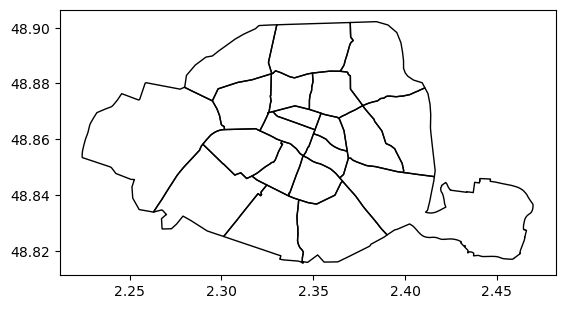

In [2]:
paris = gpd.read_file("https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/exports/geojson?lang=fr&timezone=Europe%2FBerlin")
paris.plot(fc='none')
plt.show()

In [3]:
lon, lat = get_coordinates(place='Châtelet les Halles, Paris')
lon, lat

(2.3470129, 48.8616513)

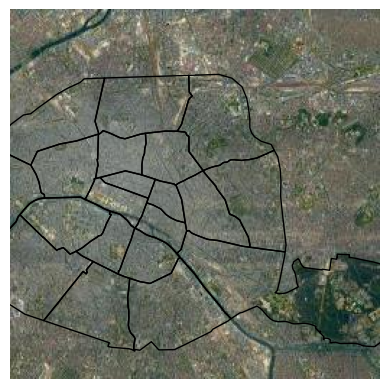

In [4]:
x, y, tile, box_tile = download_tile(lon=lon, lat=lat, zoom=11)
xmin, ymin, xmax, ymax = box_tile.total_bounds
plot(tile=tile, extent=(xmin, xmax, ymin, ymax),  show=False)
paris.plot(ax=plt.gca(), fc='none', zorder=8)
plt.show()

In [5]:
tile.shape

(256, 256, 3)

In [6]:
ds = to_raster(x, y, tile)
ds.rio.to_raster("test.tif", driver="GTiff")
ds

<xarray.Dataset> Size: 199kB
Dimensions:      (y: 256, x: 256)
Coordinates:
  * y            (y) float32 1kB 48.81 48.81 48.81 48.81 ... 48.92 48.92 48.92
  * x            (x) float32 1kB 2.285 2.286 2.287 2.288 ... 2.459 2.46 2.461
    spatial_ref  int32 4B 0
Data variables:
    red          (y, x) uint8 66kB 98 111 92 88 122 91 87 ... 92 86 98 76 91 79
    green        (y, x) uint8 66kB 100 113 94 90 124 93 ... 95 90 102 80 95 83
    blue         (y, x) uint8 66kB 76 89 72 68 103 72 72 ... 84 76 87 65 78 66

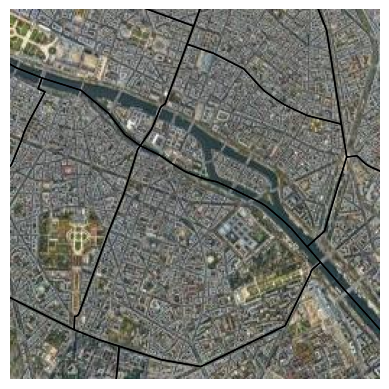

In [7]:
x, y, tile, box_tile = download_tile(lon=lon, lat=lat, zoom=13)
xmin, ymin, xmax, ymax = box_tile.total_bounds
plot(tile=tile, extent=(xmin, xmax, ymin, ymax),  show=False)
paris.plot(ax=plt.gca(), fc='none', zorder=8)
plt.show()

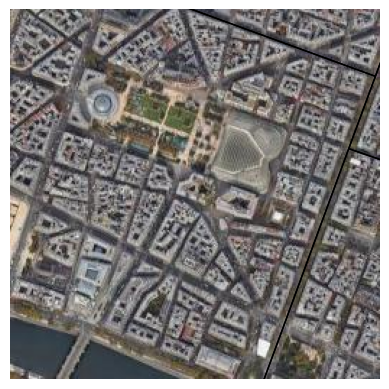

In [8]:
x, y, tile, box_tile = download_tile(lon=lon, lat=lat, zoom=15)
xmin, ymin, xmax, ymax = box_tile.total_bounds
plot(tile=tile, extent=(xmin, xmax, ymin, ymax),  show=False)
paris.plot(ax=plt.gca(), fc='none', zorder=8)
plt.show()

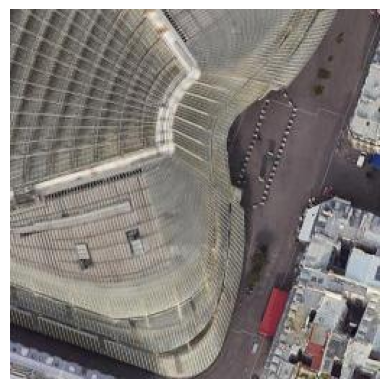

In [9]:
x, y, tile, box_tile = download_tile(lon=lon, lat=lat, zoom=18)
xmin, ymin, xmax, ymax = box_tile.total_bounds
plot(tile=tile, extent=(xmin, xmax, ymin, ymax),  show=False)
paris.plot(ax=plt.gca(), fc='none', zorder=8)
plt.show()